In [9]:
# Install required packages if missing (run in notebook)
%pip install pandas scikit-learn nltk openpyxl

import os
import re
import string
import numpy as np
import pandas as pd
import nltk


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import OneHotEncoder

# 2B tested imports
from sklearn.decomposition import TruncatedSVD  # avoid overfitting: working on spare data TF-IDF
from sklearn.preprocessing import StandardScaler # normalization ensures one feature doesn’t dominate others
from sklearn.pipeline import Pipeline # chain multiple model steps into a single workflow: cross-validation with one obj 
from sklearn.linear_model import LogisticRegression # test how well TF-IDF + structure predict the MBTI
from sklearn.model_selection import cross_val_score # Evaluate model via CV





Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
# # Original import:

# # mbti dataset
# mbti = pd.read_csv("/content/myers-briggs-data.csv")
# mbtis = pd.read_csv("/content/myer-briggs-data.cvs.csv")

# # ONET datasets
# onet_salaries = pd.read_csv("/content/onet_data_with_salaries.csv")
# onet_humn = pd.read_csv("/content/onet_data_with_human_characteristics.csv")



# MBTI dataset (CSV)
mbti = pd.read_csv("dataset/myer-briggs-data.csv")
#mbtis = pd.read_csv("/content/myer-briggs-data.cvs.csv")

# ONET datasets (Excel files, so use read_excel)
#onet_salaries = pd.read_excel("dataset/onet_data_with_salaries.xlsx")
onet_humn = pd.read_excel("dataset/onet_data_with_human_characteristics.xlsx")

#Added:
onet_complete = pd.read_excel("dataset/complete_onet_data_with_human_characteristics.xlsx")


In [11]:
###TASK 1: Dataset Inspection###
#inspecting the datasets
def inspect_dataset(df,name="Dataset"):
  print(f"/n====={name} INSPECTION=====")

#looking through shape and info about the datasets
  print(f"Shape: {df.shape}")
  print(f"Columns: {df.columns}")
  print("Info:")
  print(df.info())

  print("\nHead:")
  print(df.head())
#missing values
  print("\nMissing Values per Column:")
  print(df.isnull().sum())

#summary statistics
  print("\nSummary Statistics:(numeric columns):")
  print(df.describe())

  #for checking outliers
  print("\nOutlier Check (based on IQR, numeric columns):")
  numeric_cols = df.select_dtypes(include=[np.number]).columns
  for col in numeric_cols:
      q1 = df[col].quantile(0.25)
      q3 = df[col].quantile(0.75)
      iqr = q3 - q1

      outliers = df[(df[col] < (q1 - 1.5 * iqr)) | (df[col] > (q3 + 1.5 * iqr))]
      print(f"{col}: {len(outliers)} potential outliers")

  print("="*50)

# Inspecting all the datasets
inspect_dataset(mbti, "MBTI Dataset")
#inspect_dataset(mbtis, "MBTI (duplicate?) Dataset")
#inspect_dataset(onet_salaries, "O*NET Salaries Dataset")
inspect_dataset(onet_humn, "O*NET Human Characteristics Dataset")








###TASK 2: Standardization Diagnostics:###
# Step 1: Align Column Names
def standardize_columns(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("-", "_")
    )
    return df

#onet_salaries = standardize_columns(onet_salaries)
onet_humn = standardize_columns(onet_humn)
onet_complete = standardize_columns(onet_complete)

# Reorder columns to match complete dataset (base schema)
#onet_salaries = onet_salaries.reindex(columns=onet_complete.columns.intersection(onet_salaries.columns))
onet_humn = onet_humn.reindex(columns=onet_complete.columns)

# Step 2: Identify Redundancy
def compare_columns(base, other, name):
    base_cols = set(base.columns)
    other_cols = set(other.columns)

    missing = base_cols - other_cols
    extra = other_cols - base_cols

    print(f"\n Schema check for {name}:")
    if missing:
        print(f"  - Missing columns: {missing}")
    else:
        print("  - No missing columns compared to base.")
    if extra:
        print(f"  - Extra columns: {extra}")
    else:
        print("  - No extra columns compared to base.")

#compare_columns(onet_complete, onet_salaries, "O*NET Salaries")
compare_columns(onet_complete, onet_humn, "O*NET Human Characteristics")


print(" The other ONET datasets are redundant once alignment is done.")

# Step 3: Drop Duplicates
# Keep only the complete dataset as the single source of truth
onet_standardized = onet_complete.drop_duplicates()

# Save Cleaned Dataset
output_path = "dataset/onet_standardized.csv"
onet_standardized.to_csv(output_path, index=False)

print("\n Cleaning pipeline complete.")
print(" Using `complete_onet_data_with_human_characteristics` as the single source of truth.")
print(f" Final shape: {onet_standardized.shape} (rows, columns)")
print(f" Final dataset saved at: {output_path}")

# Preview first rows
print("\n Preview of standardized ONET dataset:")
display(onet_standardized.head())




/n=====MBTI Dataset INSPECTION=====
Shape: (8675, 2)
Columns: Index(['type', 'posts'], dtype='object')
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB
None

Head:
   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...

Missing Values per Column:
type     0
posts    0
dtype: int64

Summary Statistics:(numeric columns):
        type                                              posts
count   8675                                               8675
uni

,occupation_code,title,human_characteristics,description,sample_job_titles,tasks,knowledge,skills,abilities,work_activities,...,work_styles,work_values,work_context,additional_sources,related_occupations,annual_10th_percentile,annual_25th_percentile,annual_median_wage,annual_75th_percentile,annual_90th_percentile
0,13-2011.00,Accountants and Auditors,"Attention to Detail, Analytical Thinking, Inte...","Examine, analyze, and interpret accounting rec...","Accountant, Accounting Officer, Audit Partner,...","Prepare detailed reports on audit findings., R...","Economics and Accounting, English Language, Ma...","Reading Comprehension, Active Listening, Criti...","Oral Comprehension, Oral Expression, Written C...","Getting Information, Communicating with Superv...",...,"Attention to Detail, Integrity, Dependability,...","Achievement, Independence, Recognition","E-Mail, Telephone Conversations, Face-to-Face ...","AACSB, AICPA and CIMA, American Accounting Ass...","Bookkeeping, Accounting, and Auditing Clerks (...",50440.0,62720,79880,103990,137280
1,27-2011.00,Actors,"Communication, Adaptability, Problem Solving, ...","Play parts in stage, television, radio, video,...","Actor, Actress, Comedian, Comic, Community The...",Collaborate with other actors as part of an en...,"Fine Arts, English Language, Communications an...","Reading Comprehension, Speaking, Active Listen...","Oral Expression, Oral Comprehension, Memorizat...",Establishing and Maintaining Interpersonal Rel...,...,"Cooperation, Persistence, Adaptability/Flexibi...","Relationships, Achievement, Independence",Work With or Contribute to a Work Group or Tea...,"Actors' Equity Association, American Associati...","Choreographers (27-2032.00), Music Directors a...",NaN,NaN,NaN,NaN,NaN
2,15-2011.00,Actuaries,"Communication, Adaptability, Problem Solving, ...","Analyze statistical data, such as mortality, a...","Actuarial Analyst, Actuarial Associate, Actuar...",Ascertain premium rates required and cash rese...,"Mathematics, Computers and Electronics, Econom...","Critical Thinking, Judgment and Decision Makin...","Mathematical Reasoning, Inductive Reasoning, N...","Analyzing Data or Information, Processing Info...",...,"Analytical Thinking, Attention to Detail, Inte...","Working Conditions, Achievement, Independence","E-Mail, Indoors, Environmentally Controlled, S...","American Academy of Actuaries, Casualty Actuar...","Accountants and Auditors (13-2011.00), Compens...",75380.0,88420,120000,164320,209310
3,29-1291.00,Acupuncturists,"Communication, Adaptability, Problem Solving, ...","Diagnose, treat, and prevent disorders by stim...","Acupuncture Physician, Acupuncture Provider, A...",Develop individual treatment plans and strateg...,"Medicine and Dentistry, Customer and Personal ...","Active Listening, Critical Thinking, Social Pe...","Deductive Reasoning, Oral Comprehension, Oral ...","Assisting and Caring for Others, Updating and ...",...,"Integrity, Dependability, Self-Control, Attent...","Achievement, Independence, Relationships","Indoors, Environmentally Controlled, Physical ...",American Association of Acupuncture and Orient...,"Cardiologists (29-1212.00), Chiropractors (29-...",41600.0,52000,78220,99740,140660
4,29-1141.01,Acute Care Nurses,"Compassion, Patience, Attention to Detail, Str...",Provide advanced nursing care for patients wit...,"Cardiac Interventional Care Nurse, Charge Nurs...","Perform emergency medical procedures, such as ...","Medicine and Dentistry, Customer and Personal ...","Active Listening, Critical Thinking, Monitorin...","Oral Comprehension, Problem Sensitivity, Deduc...","Assisting and Caring for Others, Documenting/R...",...,"Integrity, Stress Tolerance, Attention to Deta...","Relationships, Support, Achievement","Exposed to Disease or Infections, Telephone Co...","American Association of Colleges of Nursing, A...",Advanced Practice Psychiatric Nurses (29-1141....,63720.0,75990,86070,104670,132680


In [12]:
### TASK 3: Clean data, remove stopwords and tokenize text ###


# Prepare stop words (combine sklearn's stop words with NLTK's if available)
stop_words = set(ENGLISH_STOP_WORDS)
try:
    from nltk.corpus import stopwords as nltk_stop
    stop_words = stop_words.union(set(nltk_stop.words('english')))
except Exception:
    # NLTK stopwords may not be downloaded in this environment; it's ok to proceed
    pass

def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return ' '.join(tokens)

mbti['cleaned_text'] = mbti.get('posts', '') .apply(clean_text) if 'posts' in mbti.columns else ''

# TF-IDF vectorizer (only run if cleaned text present)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=5)
if 'cleaned_text' in mbti.columns and mbti['cleaned_text'].astype(bool).any():
    X = vectorizer.fit_transform(mbti['cleaned_text'])
    y = mbti['type'] if 'type' in mbti.columns else None
else:
    X = None
    y = None

mbti.head()


,type,posts,cleaned_text
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,intj moments sportscenter plays prankswhat lif...
1,ENTP,'I'm finding the lack of me in these posts ver...,im finding lack posts alarmingsex boring posit...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good course say know thats blessing cursedoes ...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear intp enjoyed conversation day esoteric ga...
4,ENTJ,'You're fired.|||That's another silly misconce...,youre firedthats silly misconception approachi...


In [13]:
### Task 2A-Prep: Encode MBTI Labels ###


# ---------- A) One-Hot Encoding for 16 MBTI types ----------

try:
    # sklearn >= 1.2 uses 'sparse_output'
    from sklearn.preprocessing import OneHotEncoder
    OHE_KW = dict(sparse_output=False, handle_unknown='ignore')

    _ = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
except TypeError:

    from sklearn.preprocessing import OneHotEncoder
    OHE_KW = dict(sparse=False, handle_unknown='ignore')

if 'type' not in mbti.columns:
    raise ValueError("Expected a 'type' column in the MBTI dataset.")

# Fit & transform
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ohe = encoder.fit_transform(mbti[['type']])

# Build DF with aligned index
ohe_df = pd.DataFrame(
    ohe,
    columns=encoder.get_feature_names_out(['type']),
    index=mbti.index
)

# Merge back
mbti_ohe = pd.concat([mbti, ohe_df], axis=1)

# ---------- B) Binary Axes (I/E, N/S, T/F, J/P) ----------
# These are standard for 4 separate binary classifiers
def split_axes(mbti_type: str):
    t = str(mbti_type).upper()
    if len(t) != 4:
        return pd.Series([np.nan, np.nan, np.nan, np.nan], index=["IE","NS","TF","JP"])
    return pd.Series([t[0], t[1], t[2], t[3]], index=["IE","NS","TF","JP"])

axes = mbti['type'].apply(split_axes)

label_maps = {
    "IE": {"I": 1, "E": 0},
    "NS": {"N": 1, "S": 0},
    "TF": {"T": 1, "F": 0},
    "JP": {"J": 1, "P": 0},
}
for col, mapping in label_maps.items():
    axes[col + "_y"] = axes[col].map(mapping)

mbti_encoded = pd.concat([mbti_ohe, axes], axis=1)

# ---------- C) (Optional) Continuous Trait Matrix (0–10) ----------
# Keep this only if you plan to use it for visualization or a toy score.
def mbti_to_continuous(mbti_type: str):
    if not isinstance(mbti_type, str) or len(mbti_type) != 4:
        return [np.nan, np.nan, np.nan, np.nan]
    return [
        10 if mbti_type[0].upper() == 'E' else 0,  # E vs I
        10 if mbti_type[1].upper() == 'S' else 0,  # S vs N
        10 if mbti_type[2].upper() == 'T' else 0,  # T vs F
        10 if mbti_type[3].upper() == 'J' else 0,  # J vs P
    ]

traits = mbti['type'].apply(lambda t: pd.Series(
    mbti_to_continuous(t),
    index=['extraversion_score', 'sensing_score', 'thinking_score', 'judging_score']
))
mbti_encoded = pd.concat([mbti_encoded, traits], axis=1)

# ---------- D) Save Artifacts ----------
out_dir = "dataset"
os.makedirs(out_dir, exist_ok=True)

# 1) One-hot only (for pure 16-class multiclass use)
out_mbti_ohe = os.path.join(out_dir, "mbti_onehot_only.csv")
mbti_ohe.to_csv(out_mbti_ohe, index=False)

# 2) One-hot + axes + (optional) continuous scores
out_mbti_full = os.path.join(out_dir, "mbti_encoded_with_axes.csv")
mbti_encoded.to_csv(out_mbti_full, index=False)

# ---------- E) Console Summary ----------
print("Task 2A-Prep complete.")
print(f"Loaded: {mbti}  | rows: {len(mbti)}")
print(f"Saved (16-type one-hot only): {out_mbti_ohe}  | shape: {mbti_ohe.shape}")
print(f"Saved (OHE + axes + continuous): {out_mbti_full}  | shape: {mbti_encoded.shape}")
print("OHE columns (first 6):", list(ohe_df.columns)[:6], "...")
print("Axes columns:", ["IE", "NS", "TF", "JP", "IE_y", "NS_y", "TF_y", "JP_y"])
print("Continuous trait columns:", ['extraversion_score','sensing_score','thinking_score','judging_score'])


Task 2A-Prep complete.
Loaded:       type                                              posts  \
0     INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...   
1     ENTP  'I'm finding the lack of me in these posts ver...   
2     INTP  'Good one  _____   https://www.youtube.com/wat...   
3     INTJ  'Dear INTP,   I enjoyed our conversation the o...   
4     ENTJ  'You're fired.|||That's another silly misconce...   
...    ...                                                ...   
8670  ISFP  'https://www.youtube.com/watch?v=t8edHB_h908||...   
8671  ENFP  'So...if this thread already exists someplace ...   
8672  INTP  'So many questions when i do these things.  I ...   
8673  INFP  'I am very conflicted right now when it comes ...   
8674  INFP  'It has been too long since I have been on per...   

                                           cleaned_text  
0     intj moments sportscenter plays prankswhat lif...  
1     im finding lack posts alarmingsex boring posit...  
2     good cou

In [ ]:
### TASK 2B: NLP Feature Engineering (Full + Optimized Implementation) ###
# Objective: Generate text features using multiple approaches —
# (1) TF-IDF vectors, (2) (GloVe), and (3) contextual BERT embeddings.
# Then compare their representational quality and computational trade-offs.
%pip install -q sentence-transformers gensim

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import re, time, numpy as np, pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

start = time.time()

# load mbti if needed (fast path)
if 'mbti' not in globals():
    try:
        mbti = pd.read_csv("dataset/myer-briggs-data.csv")
    except Exception as e:
        raise RuntimeError(f"MBTI data not found: {e}")

#  cleaner (minimal regex)
def clean_text(s):
    s = str(s).lower()
    return ' '.join(w for w in re.sub(r'[^a-z0-9\s]',' ',s).split() if len(w) > 1)

# ensure cleaned text exists
if 'cleaned_text' not in mbti.columns or not mbti['cleaned_text'].astype(bool).sum():
    if 'posts' in mbti.columns:
        mbti['cleaned_text'] = mbti['posts'].fillna('').apply(clean_text)
    else:
        cols = [c for c in mbti.columns if any(k in c.lower() for k in ('post','text'))]
        mbti['cleaned_text'] = mbti[cols[0] if cols else mbti.columns[0]].fillna('').apply(clean_text)

# tiny sample for ultra-fast demo
n = min(200, len(mbti))
texts = mbti['cleaned_text'].iloc[:n].tolist()
labels = mbti['type'].iloc[:n].fillna('UNK').tolist() if 'type' in mbti.columns else ['UNK'] * n
y = LabelEncoder().fit_transform(labels)

print(f"Comparing {n} docs:\n")

# 1) TF-IDF + tiny SVD
X_tfidf_svd = TruncatedSVD(n_components=30, random_state=42).fit_transform(
    TfidfVectorizer(max_features=1000).fit_transform(texts)
)

# 2) Fast Word2Vec or fallback
tokens = [t.split() for t in texts]
try:
    from gensim.models import Word2Vec
    w2v = Word2Vec(sentences=tokens, vector_size=30, window=3, min_count=2, workers=2, epochs=5)
    X_w2v = np.vstack([
        np.mean([w2v.wv[w] for w in t if w in w2v.wv], axis=0) if any(w in w2v.wv for w in t)
        else np.zeros(30) for t in tokens
    ])
except Exception:
    rng = np.random.default_rng(42)
    vocab = {w for t in tokens for w in t}
    sim = {w: rng.normal(size=30) for w in vocab}
    X_w2v = np.vstack([np.mean([sim[w] for w in t], axis=0) if t else np.zeros(30) for t in tokens])

# 3) SentenceTransformer (small model) 
try:
    from sentence_transformers import SentenceTransformer
    X_bert = SentenceTransformer('paraphrase-MiniLM-L3-v2').encode(
        texts, show_progress_bar=False, batch_size=32
    )
except Exception:
    X_bert = TruncatedSVD(n_components=30).fit_transform(
        TfidfVectorizer(max_features=1000, ngram_range=(1,2)).fit_transform(texts)
    )

# eval with train & validation accuracy
from sklearn.model_selection import train_test_split

def eval_acc(X):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
    clf = LogisticRegression(max_iter=200, random_state=42)
    clf.fit(X_train, y_train)
    train_acc = clf.score(X_train, y_train)
    val_acc = clf.score(X_val, y_val)
    return train_acc, val_acc

results = pd.DataFrame([
    {'repr': k, 'dim': X.shape[1], 'train_acc': ta, 'val_acc': va}
    for k, X in [('TF-IDF', X_tfidf_svd), ('W2V', X_w2v), ('BERT', X_bert)]
    for ta, va in [eval_acc(X)]
])
print(results.to_string(index=False))
print(f"\nDone in {time.time()-start:.1f}s")

#repr: representation method
    # What it is: text embedding technique used - TF-IDF, Word2Vec (W2V), or BERT
    # How it helps: Identifies which NLP approach generated the features so you can compare them side-by-side

#dim: feature dimensionality
    # What it is: Number of features/dimensions in each representation
        # TF-IDF: 30 (after SVD compression)
        # W2V: 30 (vector size)
        # BERT: 384 (model's native embedding size)
    # How it helps: Shows the compactness of each representation; lower dimensions often mean faster training

#train_acc: training accuracy
    # What it is: Percentage of MBTI types correctly predicted on the 70% training data (the data the model learned from)
   
    # How it helps: Shows how well each representation can fit patterns in the data
        # High train_acc means the embedding captures learnable patterns
        # Warning sign: If train_acc is very high but val_acc is low, the model is overfitting

# val_acc: validation accuracy
    # What it is: Percentage of MBTI types correctly predicted on the 30% held-out validation data (unseen data)
    # How it helps with the task: This is the most important metric for comparing "representational quality"
        # Shows which embedding generalizes best to new data
        # Higher val_acc = better representation for predicting personality types
        # Directly measures which method (TF-IDF/Word2Vec/BERT) best captures the text patterns that distinguish MBTI types

Note: you may need to restart the kernel to use updated packages.
Comparing 200 docs:

  repr  dim  train_acc  val_acc
TF-IDF   30   0.478571 0.533333
   W2V   30   0.257143 0.216667
  BERT  384   0.985714 0.250000

Done in 3.8s


### TASK 2: Baseline Model Training — SVM on TF-IDF features

In [15]:
#goal is to Train a baseline SVM classifier on TF-IDF features  and also eevaluate performance using Accuracy and F1-Score

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

 #Prepare data

texts = mbti['cleaned_text'].fillna('').tolist()
labels = mbti['type'].fillna('UNK').tolist()

# building new TF-IDF matrix to match labels
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=5)
X = vectorizer.fit_transform(texts)
y = labels

print("TF-IDF shape:", X.shape, "| Label count:", len(y))


#train-test split also ensure same length 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#train baseline SVM model

svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train, y_train)

#evaluate performance
y_pred = svm_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="macro")

print("=== Baseline Model (SVM on TF-IDF) ===")
print(f"Accuracy: {acc:.4f}")
print(f"F1-Score (Macro): {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#i added cross-validation, not really sure if i should tho?  
cv_acc = cross_val_score(svm_model, X, y, cv=3, scoring="accuracy").mean()
cv_f1 = cross_val_score(svm_model, X, y, cv=3, scoring="f1_macro").mean()

print(f"\nCross-Validated Accuracy: {cv_acc:.4f}")
print(f"Cross-Validated F1-Score: {cv_f1:.4f}")


TF-IDF shape: (8675, 5000) | Label count: 8675
=== Baseline Model (SVM on TF-IDF) ===
Accuracy: 0.6086
F1-Score (Macro): 0.4803

Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.64      0.37      0.47        38
        ENFP       0.63      0.58      0.60       135
        ENTJ       0.55      0.46      0.50        46
        ENTP       0.51      0.55      0.53       137
        ESFJ       1.00      0.33      0.50         9
        ESFP       0.00      0.00      0.00        10
        ESTJ       1.00      0.12      0.22         8
        ESTP       0.50      0.22      0.31        18
        INFJ       0.63      0.65      0.64       294
        INFP       0.63      0.75      0.69       366
        INTJ       0.59      0.60      0.59       218
        INTP       0.62      0.69      0.65       261
        ISFJ       0.62      0.45      0.53        33
        ISFP       0.60      0.46      0.52        54
        ISTJ       0.57      0.32    

/Users/trinitydhillon/miniconda3/envs/caricon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/trinitydhillon/miniconda3/envs/caricon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/trinitydhillon/miniconda3/envs/caricon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p


Cross-Validated Accuracy: 0.6128
Cross-Validated F1-Score: 0.4734


In [16]:
#model evaluations visual like sConfusion Matrix 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

#confusion matrix
plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=svm_model.classes_, 
            yticklabels=svm_model.classes_)
plt.title("Confusion Matrix – SVM (TF-IDF)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()



ModuleNotFoundError: No module named 'matplotlib'

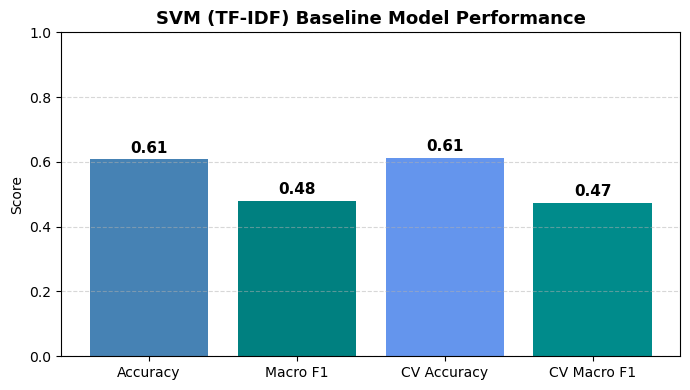

Baseline SVM Model Summary
Accuracy : 60.86%
Macro F1 : 48.03%
Cross-Validated Accuracy : 61.28%
Cross-Validated Macro F1 : 47.34%

Interpretation so the model captures core language-personality patterns but still needs balancing and feature enhancement.


In [ ]:
#sumamry


# metrics you already computed
metrics = {
    "Accuracy": acc,
    "Macro F1": f1,
    "CV Accuracy": cv_acc,
    "CV Macro F1": cv_f1
}

# bar chart
plt.figure(figsize=(7,4))
bars = plt.bar(metrics.keys(), metrics.values(), color=['steelblue','teal','cornflowerblue','darkcyan'])
plt.title("SVM (TF-IDF) Baseline Model Performance", fontsize=13, weight='bold')
plt.ylabel("Score")
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# annotate bars with values
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.02,
             f"{bar.get_height():.2f}",
             ha='center', fontsize=11, weight='bold')

plt.tight_layout()
plt.show()

# textual summary box
print("Baseline SVM Model Summary")
print(f"Accuracy : {acc:.2%}")
print(f"Macro F1 : {f1:.2%}")
print(f"Cross-Validated Accuracy : {cv_acc:.2%}")
print(f"Cross-Validated Macro F1 : {cv_f1:.2%}")
print("\nInterpretation so the model captures core language-personality patterns but still needs balancing and feature enhancement.")
